#### 利用随机森林找到对比赛胜负起决定性作用的关键因素，并尝试根据量化的比赛数据对比赛胜负进行预测

In [1]:
from DataCleaning import DataCleaning  # 导入自己写的数据预处理类
import logging
import numpy as np
import scipy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline  # 会出现异常，应该是DataCleaning我用pycharm写的，里面也有作图，不能用这个magic function，所以之后就每个图后面plt.show()了

In [2]:
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(thread)d %(levelname)s %(module)s - %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
df = pd.read_csv('.\csl_data\csl_data.csv', index_col=0)  # 读取相对路径下的csv文件
df

,possession,totalShots,corners,fouls,shotAccuracy,shotsOnTarget,shotsOffTarget,blockedShots,woodwork,bigChancesMissed,...,successfulTakeOns,interceptions,blocks,clearances,saves,foulsWon,yellowCards,redCards,Home/Away,Win
0,21,1,4,9,0,0,1,0,0,0,...,2,17,2,25,3,15,3,0,home,0
1,78,10,7,15,50,5,3,2,0,1,...,6,8,0,11,0,8,1,0,away,1
2,67,26,12,11,34,9,11,6,0,1,...,4,6,1,6,1,13,0,0,home,1
3,32,4,1,16,50,2,1,1,0,0,...,5,6,6,40,7,11,4,0,away,0
4,28,10,1,12,30,3,5,2,0,0,...,4,11,2,27,5,20,2,0,home,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,51,11,1,12,54,6,3,2,0,1,...,9,14,2,5,8,18,2,0,away,0
348,38,3,2,12,66,2,0,1,0,0,...,4,8,4,17,1,13,3,0,home,1
349,61,10,3,13,10,1,4,5,0,2,...,6,6,1,9,1,11,2,0,away,0
350,53,10,7,12,20,2,6,2,0,1,...,6,10,2,8,3,17,4,0,home,0


### 一、数据预处理

In [4]:
df.drop(df[df.Win == 2].index, inplace=True)  # 删除平局，简化成二分类问题

2022-05-08 21:00:22,444 244280 INFO utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-05-08 21:00:22,447 244280 INFO utils - NumExpr defaulting to 8 threads.


In [5]:
clean = DataCleaning(df)  # 实例化

In [6]:
clean.info()  # 得到基本信息

2022-05-08 21:00:23,390 244280 INFO DataCleaning - 
dataframe_shape:
(268, 30)
********************************************************************************
2022-05-08 21:00:23,395 244280 INFO DataCleaning - 
dataframe_head(5):
   possession  totalShots  corners  fouls  shotAccuracy  shotsOnTarget  \
0          21           1        4      9             0              0   
1          78          10        7     15            50              5   
2          67          26       12     11            34              9   
3          32           4        1     16            50              2   
4          28          10        1     12            30              3   

   shotsOffTarget  blockedShots  woodwork  bigChancesMissed  ...  \
0               1             0         0                 0  ...   
1               3             2         0                 1  ...   
2              11             6         0                 1  ...   
3               1             1         0           

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 351
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   possession             268 non-null    int64 
 1   totalShots             268 non-null    int64 
 2   corners                268 non-null    int64 
 3   fouls                  268 non-null    int64 
 4   shotAccuracy           268 non-null    int64 
 5   shotsOnTarget          268 non-null    int64 
 6   shotsOffTarget         268 non-null    int64 
 7   blockedShots           268 non-null    int64 
 8   woodwork               268 non-null    int64 
 9   bigChancesMissed       268 non-null    int64 
 10  offsides               268 non-null    int64 
 11  passingAccuracy        268 non-null    int64 
 12  totalPasses            268 non-null    int64 
 13  successfulPasses       268 non-null    int64 
 14  totalCrosses           268 non-null    int64 
 15  successfulCrosses      

In [7]:
clean.drop_null(axis=0, how='any')  # 删除空值

2022-05-08 21:00:26,007 244280 INFO DataCleaning - Before drop:
possession               0
totalShots               0
corners                  0
fouls                    0
shotAccuracy             0
shotsOnTarget            0
shotsOffTarget           0
blockedShots             0
woodwork                 0
bigChancesMissed         0
offsides                 0
passingAccuracy          0
totalPasses              0
successfulPasses         0
totalCrosses             0
successfulCrosses        0
successfulTackles        0
tackleAccuracy           0
successfulDuels          0
successfulAerialDuels    0
successfulTakeOns        0
interceptions            0
blocks                   0
clearances               0
saves                    0
foulsWon                 0
yellowCards              0
redCards                 0
Home/Away                0
Win                      0
dtype: int64


2022-05-08 21:00:26,015 244280 INFO DataCleaning - After drop:
possession               0
totalShots           

In [8]:
lst = list(df.columns)  # 提取dataframe的列
lst = lst[:-2]  # 切片找出需要作图的列

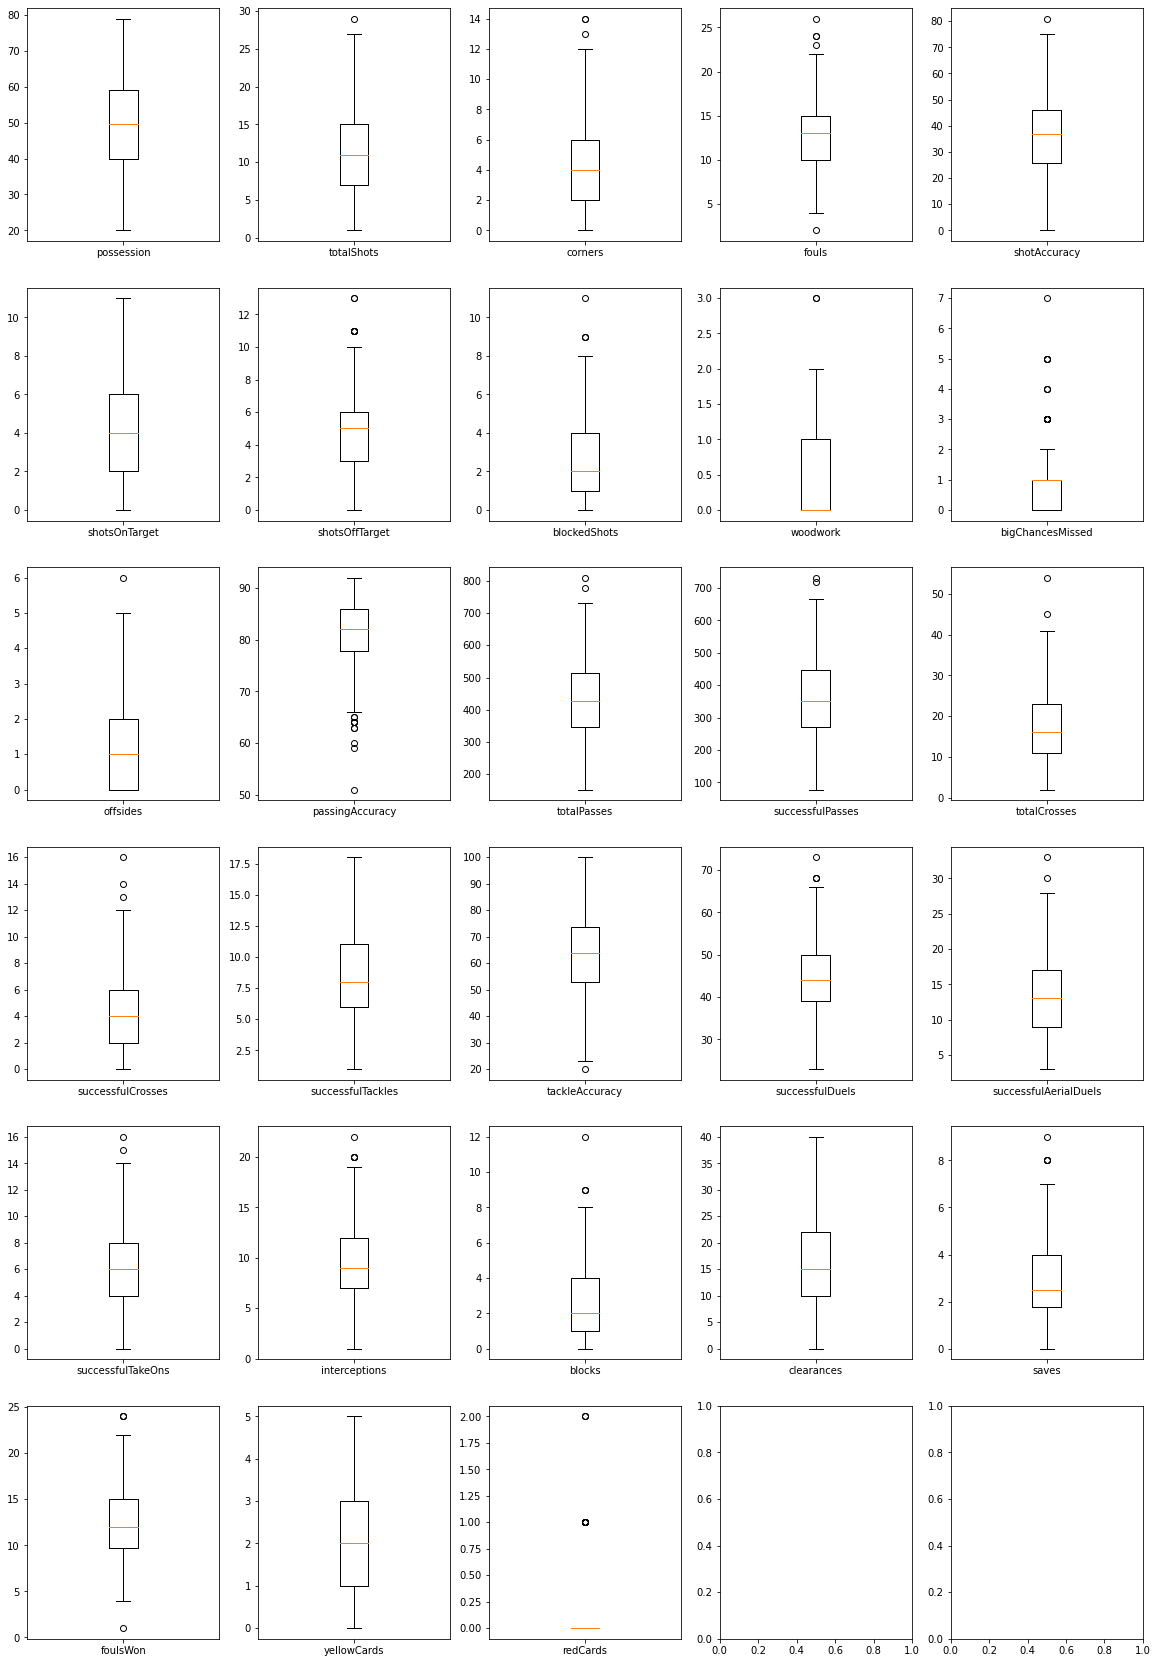

In [11]:
clean.boxplot(col=lst, onefig=False, figsize=(20,30))  # 画出箱线图，查看数据分布以及异常值

#### PS: 因为异常值都比较合理，也能够反应对比赛走势的印象，所以这里不对异常值进行处理

In [10]:
df = clean.get()  # 获得预处理后的dataframe

2022-05-08 21:00:31,464 244280 INFO DataCleaning - Get cleaned data


In [14]:
df

,possession,totalShots,corners,fouls,shotAccuracy,shotsOnTarget,shotsOffTarget,blockedShots,woodwork,bigChancesMissed,...,successfulTakeOns,interceptions,blocks,clearances,saves,foulsWon,yellowCards,redCards,Home/Away,Win
0,21,1,4,9,0,0,1,0,0,0,...,2,17,2,25,3,15,3,0,home,0
1,78,10,7,15,50,5,3,2,0,1,...,6,8,0,11,0,8,1,0,away,1
2,67,26,12,11,34,9,11,6,0,1,...,4,6,1,6,1,13,0,0,home,1
3,32,4,1,16,50,2,1,1,0,0,...,5,6,6,40,7,11,4,0,away,0
4,28,10,1,12,30,3,5,2,0,0,...,4,11,2,27,5,20,2,0,home,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,51,11,1,12,54,6,3,2,0,1,...,9,14,2,5,8,18,2,0,away,0
348,38,3,2,12,66,2,0,1,0,0,...,4,8,4,17,1,13,3,0,home,1
349,61,10,3,13,10,1,4,5,0,2,...,6,6,1,9,1,11,2,0,away,0
350,53,10,7,12,20,2,6,2,0,1,...,6,10,2,8,3,17,4,0,home,0


In [15]:
df.Win.nunique()  # 查看Win属性有几类标签

2

In [16]:
df.Win.value_counts()  # 查看不同类标签对应的记录数量，考虑是否需要下采样或过采样

0    134
1    134
Name: Win, dtype: int64

#### 因为数据比较少，也比较均很，就不需要考虑下采样或过采样了

In [17]:
x = df.iloc[:,:-2]
x.head(5)

,possession,totalShots,corners,fouls,shotAccuracy,shotsOnTarget,shotsOffTarget,blockedShots,woodwork,bigChancesMissed,...,successfulDuels,successfulAerialDuels,successfulTakeOns,interceptions,blocks,clearances,saves,foulsWon,yellowCards,redCards
0,21,1,4,9,0,0,1,0,0,0,...,39,9,2,17,2,25,3,15,3,0
1,78,10,7,15,50,5,3,2,0,1,...,47,20,6,8,0,11,0,8,1,0
2,67,26,12,11,34,9,11,6,0,1,...,53,26,4,6,1,6,1,13,0,0
3,32,4,1,16,50,2,1,1,0,0,...,42,15,5,6,6,40,7,11,4,0
4,28,10,1,12,30,3,5,2,0,0,...,46,16,4,11,2,27,5,20,2,0


In [18]:
y = df.Win
y.head(5)

0    0
1    1
2    1
3    0
4    1
Name: Win, dtype: int64

### 二、过采样(如果需要的话)

In [19]:
# from imblearn.over_sampling import SMOTE # 使用imlbearn库中上采样方法中的SMOTE接口

# smo = SMOTE(random_state=42) # 实例化，random_state相当于随机数种子的作用
# x_smo, y_smo = smo.fit_resample(x, y)

In [20]:
# df.Win.value_counts()  # 重新查看数据比例

### 模型训练

In [21]:
seed=5
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=seed)  # 注意这里的x和y，若执行上述过采样操作，需改成x_smo, y_smo

In [22]:
rfc = RandomForestClassifier()     #实例化 
rfc = rfc.fit(xtrain,ytrain)       #用训练集数据训练模型 

result = rfc.score(xtest,ytest)    #导入测试集，rfc的接口score计算的是模型准确率accuracy
logger.info('score: {}'.format(result))

2022-05-08 21:01:19,462 244280 INFO <ipython-input-22-6215e59e25fd> - score: 0.6790123456790124


In [23]:
logger.info('所有的树:%s' % rfc.estimators_[:5])  # 查看决策树

2022-05-08 21:01:19,849 244280 INFO <ipython-input-23-aa5cc31a23af> - 所有的树:[DecisionTreeClassifier(max_features='auto', random_state=601942261), DecisionTreeClassifier(max_features='auto', random_state=1933082932), DecisionTreeClassifier(max_features='auto', random_state=191009162), DecisionTreeClassifier(max_features='auto', random_state=1191093232), DecisionTreeClassifier(max_features='auto', random_state=434241572)]


In [24]:
logger.info(rfc.classes_)  # 标签类
logger.info(rfc.n_classes_)  # 标签类的个数

2022-05-08 21:01:21,751 244280 INFO <ipython-input-24-878647ca6a26> - [0 1]
2022-05-08 21:01:21,752 244280 INFO <ipython-input-24-878647ca6a26> - 2


### 预测结果

In [25]:
logger.info('判定结果：%s' % rfc.predict(xtest))

2022-05-08 21:01:22,477 244280 INFO <ipython-input-25-be8ba6747063> - 判定结果：[1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 1 1]


In [26]:
logger.info('判定结果：%s' % rfc.predict_proba(xtest)[:,:])   #标签是0、1的可能性

2022-05-08 21:01:22,856 244280 INFO <ipython-input-26-27deb2b75018> - 判定结果：[[0.4  0.6 ]
 [0.69 0.31]
 [0.82 0.18]
 [0.74 0.26]
 [0.36 0.64]
 [0.42 0.58]
 [0.14 0.86]
 [0.52 0.48]
 [0.64 0.36]
 [0.37 0.63]
 [0.36 0.64]
 [0.72 0.28]
 [0.48 0.52]
 [0.64 0.36]
 [0.57 0.43]
 [0.31 0.69]
 [0.44 0.56]
 [0.49 0.51]
 [0.57 0.43]
 [0.79 0.21]
 [0.81 0.19]
 [0.59 0.41]
 [0.58 0.42]
 [0.55 0.45]
 [0.86 0.14]
 [0.84 0.16]
 [0.43 0.57]
 [0.66 0.34]
 [0.5  0.5 ]
 [0.63 0.37]
 [0.45 0.55]
 [0.54 0.46]
 [0.51 0.49]
 [0.41 0.59]
 [0.4  0.6 ]
 [0.37 0.63]
 [0.64 0.36]
 [0.72 0.28]
 [0.62 0.38]
 [0.83 0.17]
 [0.75 0.25]
 [0.59 0.41]
 [0.25 0.75]
 [0.79 0.21]
 [0.78 0.22]
 [0.17 0.83]
 [0.51 0.49]
 [0.64 0.36]
 [0.54 0.46]
 [0.23 0.77]
 [0.68 0.32]
 [0.65 0.35]
 [0.71 0.29]
 [0.42 0.58]
 [0.37 0.63]
 [0.66 0.34]
 [0.3  0.7 ]
 [0.82 0.18]
 [0.48 0.52]
 [0.38 0.62]
 [0.68 0.32]
 [0.46 0.54]
 [0.49 0.51]
 [0.49 0.51]
 [0.28 0.72]
 [0.52 0.48]
 [0.56 0.44]
 [0.43 0.57]
 [0.37 0.63]
 [0.47 0.53]
 [0.65 0.35]
 [

In [27]:
logger.info('判定结果：%s' % rfc.predict_proba(xtest)[:,1])   #标签是1的可能性

2022-05-08 21:01:23,137 244280 INFO <ipython-input-27-3448eb9e21a2> - 判定结果：[0.6  0.31 0.18 0.26 0.64 0.58 0.86 0.48 0.36 0.63 0.64 0.28 0.52 0.36
 0.43 0.69 0.56 0.51 0.43 0.21 0.19 0.41 0.42 0.45 0.14 0.16 0.57 0.34
 0.5  0.37 0.55 0.46 0.49 0.59 0.6  0.63 0.36 0.28 0.38 0.17 0.25 0.41
 0.75 0.21 0.22 0.83 0.49 0.36 0.46 0.77 0.32 0.35 0.29 0.58 0.63 0.34
 0.7  0.18 0.52 0.62 0.32 0.54 0.51 0.51 0.72 0.48 0.44 0.57 0.63 0.53
 0.35 0.45 0.49 0.47 0.32 0.47 0.72 0.47 0.67 0.73 0.69]


In [28]:
#对比一下，（1）使用predict_proba()接口，然后将标签值为1的概率>0.5的样本即判断其属于标签值为1的那一类；
#（2）直接使用predict接口，判断其属于哪一类
d1=np.array(pd.Series(rfc.predict_proba(xtest)[:,1]>0.5).map({False:0, True:1}))
d2=rfc.predict(xtest)
np.array_equal(d1,d2)

True

In [29]:
# 计算ROC曲线下的面积计为准确率。若解决多分类问题， multi_class选择one vs one以提高准确率
logger.info('roc_auc_score: {}'.format(roc_auc_score(ytest, rfc.predict_proba(xtest)[:,1]))) # multi_class='ovo' or 'ovr'

2022-05-08 21:01:24,113 244280 INFO <ipython-input-29-8ed6e134f13e> - roc_auc_score: 0.7729813664596273


### 特征的重要性与可视化

In [30]:
logger.info('各feature的重要性\n：{}'.format(rfc.feature_importances_))

2022-05-08 21:01:25,349 244280 INFO <ipython-input-30-0b772b2532fa> - 各feature的重要性
：[0.04705205 0.06052907 0.01889192 0.03202115 0.08705945 0.09808829
 0.02940424 0.02028763 0.00823206 0.02218024 0.02405599 0.04032608
 0.0589982  0.04451667 0.0402683  0.02797251 0.02552216 0.0344791
 0.03043385 0.04614652 0.02334173 0.03388225 0.02461277 0.044821
 0.01953898 0.03121407 0.01989646 0.00622725]


Feature ranking:
 1) shotsOnTarget                  0.098088
 2) shotAccuracy                   0.087059
 3) totalShots                     0.060529
 4) totalPasses                    0.058998
 5) possession                     0.047052
 6) successfulAerialDuels          0.046147
 7) clearances                     0.044821
 8) successfulPasses               0.044517
 9) passingAccuracy                0.040326
10) totalCrosses                   0.040268


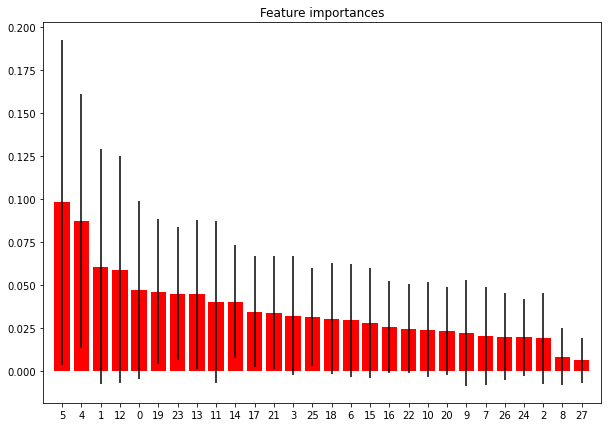

In [32]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)  # 计算每颗决策树对某个特征打分的标准差
indices = np.argsort(importances)[::-1]
# 打印排序号的特征（为了美观用print，不用logger，哈哈哈，不知道老师会不会打我）
print("Feature ranking:")
for i in range(min(10,xtrain.shape[1])):    
    print("%2d) %-*s %f" % (i + 1, 30, xtrain.columns[indices[i]], importances[indices[i]]))
# 绘制带标准差（误差线）的排序柱状图，误差线表明了不同决策树打分的离散程度
plt.figure(figsize=(10,7))
plt.title("Feature importances")
plt.bar(range(xtrain.shape[1]), importances[indices],  color="r", yerr=std[indices], align="center")
plt.xticks(range(xtrain.shape[1]), indices)
plt.xlim([-1, xtrain.shape[1]])
plt.show()

#### 可以看到，影响比赛胜负的决定性因素排名前十是：
1. 射正次数
2. 射门准确率
3. 总射门数
4. 总传球数
5. 控球率
6. 成功空中争顶数
7. 解围次数
8. 成功传球数
9. 传球准确率
10. 总长传数

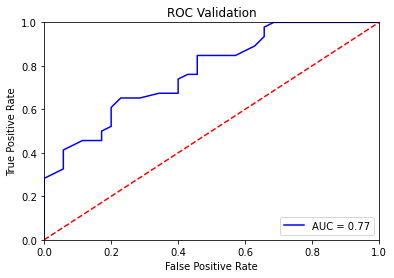

In [33]:
# 绘制ROC曲线
predictions_validation = rfc.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, predictions_validation)
roc_auc = auc(fpr, tpr)  # 计算roc_auc
plt.title('ROC Validation')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
# 随机森林与决策树的对比
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)  # 决策树
scores = cross_val_score(clf, xtrain, ytrain,cv=5)  # 5折交叉验证
logger.info(scores.mean())  # 评分均值                             

clf2 = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)  # 随机森林
scores = cross_val_score(clf2, xtrain, ytrain,cv=5)  # 5折交叉验证
logger.info(scores.mean())  # 评分均值 

2022-05-08 21:01:33,842 244280 INFO <ipython-input-34-636a1fdc471e> - 0.6849217638691323
2022-05-08 21:01:33,922 244280 INFO <ipython-input-34-636a1fdc471e> - 0.6300142247510668


### 用网格搜索法提高模型准确度

In [35]:
rfc.get_params()  # 随机森林分类器的参数

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
param_test1 = {'n_estimators': range(50,220,5)}  # 设置参数搜索范围,这里设置决策树（分类器）个数
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=2, 
                                                           min_samples_leaf=2,
                                                           random_state=10), 
                        param_grid = param_test1, 
                        scoring='roc_auc',   # 评分标准
                        n_jobs=5,  # 选择用5个核心跑
                        cv=5)  # 交叉验证
gsearch1.fit(xtrain, ytrain)  # 训练
logger.info('\nBest params:\n{}\nBest score:\n{}'.format(gsearch1.best_params_, gsearch1.best_score_))  #输出结果

2022-05-08 21:01:52,357 244280 INFO <ipython-input-37-2b9fc7b97192> - 
Best params:
{'n_estimators': 195}
Best score:
0.7224303405572756


In [38]:
param_test2 = {'min_samples_split': range(40,101,5), 'min_samples_leaf':range(1, 51, 5)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=195, 
                                                           random_state=10), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=5,
                        cv=5)
gsearch2.fit(xtrain,ytrain)
logger.info('\nBest params:\n{}\nBest score:\n{}'.format(gsearch2.best_params_, gsearch2.best_score_))

2022-05-08 21:02:24,655 244280 INFO <ipython-input-38-dff30b1fcf13> - 
Best params:
{'min_samples_leaf': 21, 'min_samples_split': 55}
Best score:
0.7557361541107671


In [39]:
param_test3 = {'criterion':['gini', 'entropy'], 'class_weight':[None, 'balanced']}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=195, 
                                                           min_samples_split=55, 
                                                           min_samples_leaf=21,
                                                           random_state=10), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=5,
                        cv=5)
gsearch3.fit(xtrain,ytrain)
logger.info('\nBest params:\n{}\nBest score:\n{}'.format(gsearch3.best_params_, gsearch3.best_score_))

2022-05-08 21:02:25,802 244280 INFO <ipython-input-39-00274e9cddc4> - 
Best params:
{'class_weight': None, 'criterion': 'gini'}
Best score:
0.7557361541107671


|||
|---|---|
|gini None|gini balanced|
|entropy None|entropy balanced|

#### param_test3的网格搜索示例如上表

In [40]:
#整合所有最优参数值，得到最优评分
logger.info('roc_auc_score of best rfc: {}'.format(roc_auc_score(ytest, gsearch3.best_estimator_.predict_proba(xtest)[:,1])))

2022-05-08 21:02:25,824 244280 INFO <ipython-input-40-a791f0cbb304> - roc_auc_score of best rfc: 0.7490683229813664
